In [1]:
from transformers import AutoAdapterModel, AdapterConfig

In [2]:
model = AutoAdapterModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertAdapterModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertAdapterModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertAdapterModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
a = model.load_adapter("adapters/TREC-2-BERT-pfeiffer")

Overwriting existing adapter 'TREC-2-BERT-pfeiffer'.
Overwriting existing head 'TREC-2-BERT-pfeiffer'


In [11]:
model.save_adapter?

In [7]:
model.add_classification_head("head", num_labels=2)

In [8]:
model.add_adapter("head")
model.train_adapter("head")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy

from dataloaders import *
from util import Config
from viz_utils import *


In [13]:
datasets = ["TREC-2", "SUBJ", "AGN-2", "TREC-6", "AGN-4", "SST"]
dataset_map = {"TREC-2": "TREC-2", "SUBJ": "SUBJ", "AGN-2": "AGN-2", "TREC-6": "TREC-full", "SST": "SST", "COLA": "COLA", "AGN-4": "ag_news-full"}
models = ["BERT", "ELECTRA"]
load_anti = False
n = 0 # AL step at which evaluation (AUC) starts
model = "BERT"
mode = "ada"
dataset = "TREC-2"

aucs = []
trs = []
try:
    experiments, meta = load_results(
        base_dir=f"results/",
        dataset=dataset_map[dataset],
        model=model,
    )
except:
    print(f"No experiments for {dataset}-{model}-{mode}")
for load_mode in ["last", "best"]:
    if mode == "short" and load_mode == "best":
        continue
    mode_print = mode if load_mode == "last" else f"{mode}-besov"
    print(f"Loading {dataset} -- {mode_print} -- {model}")
    df_tr_i = results_to_df(experiments, mode=load_mode)

    df_tr_i["model"] = model
    df_tr_i["mode"] = mode_print
    df_tr_i["dataset"] = dataset
    df_tr_i = df_tr_i.reset_index().set_index(["dataset", "model", "mode", "sampler", "experiment", "al_iter"])
    trs.append(df_tr_i)
        
    df_auc_i = al_auc(df_tr_i)
    df_auc_i["mode"] = mode_print
    df_auc_i = df_auc_i.reset_index().set_index(["mode", "sampler"])
    aucs.append(df_auc_i)
                
        


# plot_besov_index(df_tr, ci=0)
# plot_al_accuracy(df_tr, metric="f1_micro", ci=0)
df_tr = pd.concat(trs)
df_auc = pd.concat(aucs)

TREC-2-BERT
Loading TREC-2 -- ada -- BERT
Loading TREC-2 -- ada-besov -- BERT


In [3]:
df_auc

acc_auc  \
mode      sampler                                                      
ada       entropy  [0.917352537722908, 0.9225537265660724, 0.9224...   
          random   [0.8982624599908551, 0.901406035665295, 0.8875...   
ada-besov entropy  [0.9188385916780979, 0.9239254686785551, 0.923...   
          random   [0.8995770461819844, 0.9022062185642431, 0.888...   

                                                           micro_auc  \
mode      sampler                                                      
ada       entropy  [0.917352537722908, 0.9225537265660724, 0.9224...   
          random   [0.8982624599908551, 0.901406035665295, 0.8875...   
ada-besov entropy  [0.9188385916780979, 0.9239254686785551, 0.923...   
          random   [0.8995770461819844, 0.9022062185642431, 0.888...   

                                                           macro_auc  \
mode      sampler                                                      
ada       entropy  [0.9169995962810528, 0.9224465589426897, 0.922...   
          random   [0.8979062206759953, 0.9010014071273366, 0.887...   
ada-besov entropy  [0.9185112118411727, 0.9238325441528273, 0.923...   
          random   [0.8992309860024681, 0.9017537967519369, 0.887...   

                                                             acc_avg  \
mode      sampler                                                      
ada       entropy  [0.9148797920727745, 0.9202945635694174, 0.919...   
          random   [0.8965778644141217, 0.9000433181719731, 0.886...   
ada-besov entropy  [0.9165042235217673, 0.9215941087286118, 0.920...   
          random   [0.897877409573316, 0.900909681611436, 0.88683...   

                                                           micro_avg  \
mode      sampler                                                      
ada       entropy  [0.9148797920727745, 0.9202945635694174, 0.919...   
          random   [0.8965778644141218, 0.9000433181719731, 0.886...   
ada-besov entropy  [0.9165042235217673, 0.9215941087286118, 0.920...   
          random   [0.897877409573316, 0.900909681611436, 0.88683...   

                                                           macro_avg  \
mode      sampler                                                      
ada       entropy  [0.9145303372964524, 0.9201819268022394, 0.919...   
          random   [0.896224320880439, 0.8996481980738046, 0.8856...   
ada-besov entropy  [0.9161878154766455, 0.9214949654223696, 0.920...   
          random   [0.8975424836667054, 0.900469785317158, 0.8863...   

                   acc_auc_mean  acc_auc_std  micro_auc_mean  micro_auc_std  \
mode      sampler                                                             
ada       entropy      0.919627     0.002420        0.919627       0.002420   
          random       0.894696     0.004767        0.894696       0.004767   
ada-besov entropy      0.921525     0.002249        0.921525       0.002249   
          random       0.896216     0.004821        0.896216       0.004821   

                   macro_auc_mean  macro_auc_std  acc_avg_mean  acc_avg_std  \
mode      sampler                                                             
ada       entropy        0.919292       0.002552      0.917197     0.002360   
          random         0.894361       0.004758      0.893307     0.004746   
ada-besov entropy        0.921275       0.002318      0.919147     0.002150   
          random         0.895883       0.004816      0.894910     0.004790   

                   micro_avg_mean  micro_avg_std  macro_avg_mean  \
mode      sampler                                                  
ada       entropy        0.917197       0.002360        0.916860   
          random         0.893307       0.004746        0.892970   
ada-besov entropy        0.919147       0.002150        0.918895   
          random         0.894910       0.004790        0.894580   

                   macro_avg_std  
mode      sampler                 
ada       entropy       0.002479  

In [5]:
df_tr[df_tr.index.get_level_values("mode") == "ada-besov"]

labeled  \
dataset model mode      sampler         experiment al_iter            
ag_news BERT  ada-besov entropy_dropout 0          0            100   
                                                   1            150   
                                                   2            200   
                                                   3            250   
                                                   4            300   
...                                                             ...   
                        dal             4          54          1987   
                                                   55          1987   
                                                   56          1987   
                                                   57          1987   
                                                   58          1987   

                                                            train_loss  \
dataset model mode      sampler         experiment al_iter               
ag_news BERT  ada-besov entropy_dropout 0          0          0.461921   
                                                   1          0.464392   
                                                   2          0.427918   
                                                   3          0.470693   
                                                   4          0.426103   
...                                                                ...   
                        dal             4          54         0.042552   
                                                   55         0.059556   
                                                   56         0.040844   
                                                   57         0.046132   
                                                   58         0.068044   

                                                            test_accuracy  \
dataset model mode      sampler         experiment al_iter                  
ag_news BERT  ada-besov entropy_dropout 0          0             0.781893   
                                                   1             0.833333   
                                                   2             0.868313   
                                                   3             0.888889   
                                                   4             0.909465   
...                                                                   ...   
                        dal             4          54            0.954733   
                                                   55            0.956790   
                                                   56            0.956790   
                                                   57            0.954733   
                                                   58            0.956790   

                                                            f1_micro  f1_macro  
dataset model mode      sampler         experiment al_iter                      
ag_news BERT  ada-besov entropy_dropout 0          0        0.781893  0.779744  
                                                   1        0.833333  0.832464  
                                                   2        0.868313  0.867809  
                                                   3        0.888889  0.888464  
                                                   4        0.909465  0.909205  
...                                                              ...       ...  
                        dal             4          54       0.954733  0.954732  
                                                   55       0.956790  0.956786  
                                                   56       0.956790  0.956781  
                                                   57       0.954733  0.954720  
                                                   58       0.956790  0.956775  

[1180 rows x 5 columns]

(100.0, 1000.0)

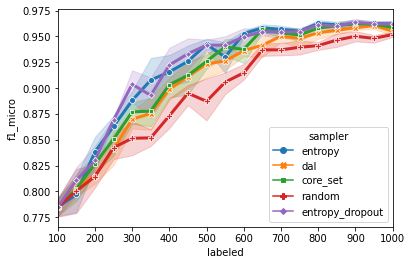

In [14]:
g = sns.lineplot(
data=df_tr[df_tr.index.get_level_values("mode") == "ada"],
    x="labeled",
    y="f1_micro",
    hue="sampler",
    style="sampler",
    markers=True,
    dashes=False,
    ci=95,
    linewidth=3,
)
# g.set_ylim(0.86, 0.96)
g.set_xlim(100, 1000)